In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import datetime
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from pathlib import Path
import pickle
from IPython.display import display, Markdown, Latex

# Initialize Model

In [2]:
bit_lengths = [7,6,5,4,3,2,1]

In [3]:
model_path = Path('./models')

In [21]:
fig_path = Path('./figures')

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_data = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def create_model(bit_length):
    alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    
    alexnet.classifier[4] = nn.Linear(4096,1024)
    alexnet.classifier[6] = nn.Linear(1024,10)
    
    alexnet.load_state_dict(torch.load(model_path  / f'dt_quantized_model_bl_{bit_length}',map_location=device))
    alexnet.eval()
    return alexnet

In [15]:
print(device)
for bit_length in bit_lengths:
    alexnet = create_model(bit_length)
    alexnet.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = alexnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Bit Length {bit_length} Accuracy of the network on the 10000 test images: {100 * correct / total} %')

cuda:0


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
100%|██████████| 2500/2500 [00:40<00:00, 61.72it/s] 
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


Bit Length 7 Accuracy of the network on the 10000 test images: 85.22 %


100%|██████████| 2500/2500 [00:18<00:00, 134.15it/s]
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


Bit Length 6 Accuracy of the network on the 10000 test images: 85.12 %


100%|██████████| 2500/2500 [00:17<00:00, 143.96it/s]
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


Bit Length 5 Accuracy of the network on the 10000 test images: 85.06 %


100%|██████████| 2500/2500 [00:16<00:00, 151.91it/s]
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


Bit Length 4 Accuracy of the network on the 10000 test images: 84.87 %


100%|██████████| 2500/2500 [00:17<00:00, 143.64it/s]
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


Bit Length 3 Accuracy of the network on the 10000 test images: 83.51 %


100%|██████████| 2500/2500 [00:17<00:00, 145.43it/s]
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


Bit Length 2 Accuracy of the network on the 10000 test images: 83.51 %


100%|██████████| 2500/2500 [00:16<00:00, 147.20it/s]

Bit Length 1 Accuracy of the network on the 10000 test images: 25.24 %


In [26]:
accuracies = {7: 85.22, 6: 85.12, 5: 85.06, 4: 84.87, 3: 83.51, 2: 83.51}#, 1: 25.24}

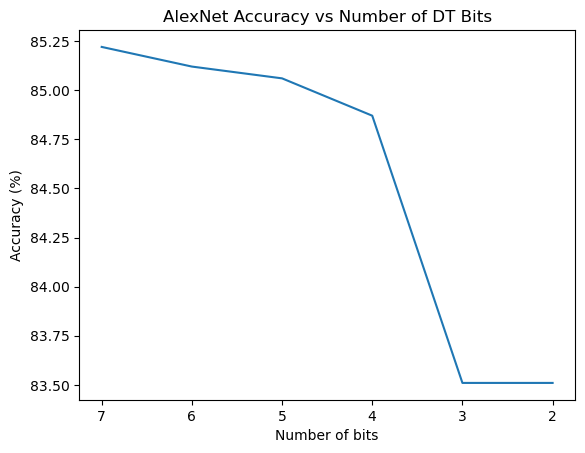

In [30]:
plt.plot(list(accuracies.keys()), list(accuracies.values()))
plt.gca().invert_xaxis()
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of bits')
plt.title('AlexNet Accuracy vs Number of DT Bits')
plt.savefig(fig_path / 'alex_accuracy_v_bits.png')

---

In [17]:
counts_path = Path('./counts')

In [18]:
counts = []
for bit_length in bit_lengths:
    with open(counts_path / f'dt_counts_bl_{bit_length}.pkl', 'rb') as f:
        counts.append(pickle.load(f))
        print(f'{bit_length} bit exponent counts: {counts[-1]}')

7 bit exponent counts: {0: 30518764, 1: 12468009, 2: 1291749, 3: 129113, 4: 12769, 5: 1267, 6: 153, 7: 0}
6 bit exponent counts: {0: 30518764, 1: 12468009, 2: 1291749, 3: 129113, 4: 12769, 5: 1420, 6: 0, 7: 0}
5 bit exponent counts: {0: 30518764, 1: 12468009, 2: 1291749, 3: 129113, 4: 14189, 5: 0, 6: 0, 7: 0}
4 bit exponent counts: {0: 30518764, 1: 12468009, 2: 1291749, 3: 143302, 4: 0, 5: 0, 6: 0, 7: 0}
3 bit exponent counts: {0: 30518764, 1: 12468009, 2: 1435051, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
2 bit exponent counts: {0: 30518764, 1: 13903060, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
1 bit exponent counts: {0: 44421824, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}


In [19]:
alexnetb7 = create_model(7)
alexnetb2 = create_model(2)

Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


In [21]:
alexnetb7.features[0].weight

Parameter containing:
tensor([[[[ 1.1771e-01,  9.3614e-02,  9.4541e-02,  ...,  5.5612e-02,
            2.1318e-02,  4.9124e-02],
          [ 7.4768e-02,  3.8571e-02,  5.2812e-02,  ...,  2.5516e-02,
           -1.1275e-02,  3.7977e-03],
          [ 7.4836e-02,  3.8302e-02,  5.4801e-02,  ...,  4.3016e-02,
            1.0017e-02,  1.2964e-02],
          ...,
          [ 9.1878e-02,  1.0297e-01,  6.6533e-02,  ..., -2.0118e-01,
           -1.2831e-01, -1.1089e-01],
          [ 4.1965e-02,  6.4854e-02,  3.4335e-02,  ..., -2.0219e-01,
           -1.1254e-01, -1.0682e-01],
          [ 4.7127e-02,  6.2411e-02,  2.4200e-02,  ..., -1.1718e-01,
           -9.5527e-02, -8.2790e-02]],

         [[-7.2491e-02, -5.7711e-02, -8.0233e-02,  ..., -5.6304e-04,
           -2.4633e-02,  2.5337e-02],
          [-6.8611e-02, -6.7417e-02, -7.5770e-02,  ..., -3.8183e-03,
           -2.9831e-02,  1.0142e-02],
          [-9.9456e-02, -8.5483e-02, -1.0439e-01,  ..., -2.6303e-02,
           -2.2193e-02,  6.5756e-03]

In [22]:
alexnetb2.features[0].weight

Parameter containing:
tensor([[[[ 0.1177,  0.0936,  0.0945,  ...,  0.0556,  0.0213,  0.0491],
          [ 0.0748,  0.0386,  0.0528,  ...,  0.0255, -0.0113,  0.0000],
          [ 0.0748,  0.0383,  0.0548,  ...,  0.0430,  0.0100,  0.0130],
          ...,
          [ 0.0919,  0.1030,  0.0665,  ..., -0.2012, -0.1283, -0.1109],
          [ 0.0420,  0.0649,  0.0343,  ..., -0.2022, -0.1125, -0.1068],
          [ 0.0471,  0.0624,  0.0242,  ..., -0.1172, -0.0955, -0.0828]],

         [[-0.0725, -0.0577, -0.0802,  ..., -0.0000, -0.0246,  0.0253],
          [-0.0686, -0.0674, -0.0758,  ..., -0.0000, -0.0298,  0.0101],
          [-0.0995, -0.0855, -0.1044,  ..., -0.0263, -0.0222,  0.0000],
          ...,
          [-0.1475, -0.0849, -0.0938,  ...,  0.3083,  0.1788,  0.0804],
          [-0.1430, -0.0736, -0.0715,  ...,  0.2036,  0.1625,  0.0931],
          [-0.0855, -0.0400, -0.0510,  ...,  0.1627,  0.1475,  0.1006]],

         [[-0.0235, -0.0000, -0.0277,  ...,  0.0399, -0.0070,  0.0319],
        

In [23]:
alexnetb2 = create_model(1)

Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


In [24]:
alexnetb2.features[0].weight

Parameter containing:
tensor([[[[ 0.1177,  0.0936,  0.0945,  ...,  0.0556,  0.0213,  0.0491],
          [ 0.0748,  0.0386,  0.0528,  ...,  0.0255, -0.0113,  0.0415],
          [ 0.0748,  0.0383,  0.0548,  ...,  0.0430,  0.0100,  0.0130],
          ...,
          [ 0.0919,  0.1030,  0.0665,  ..., -0.2012, -0.1283, -0.1109],
          [ 0.0420,  0.0649,  0.0343,  ..., -0.2022, -0.1125, -0.1068],
          [ 0.0471,  0.0624,  0.0242,  ..., -0.1172, -0.0955, -0.0828]],

         [[-0.0725, -0.0577, -0.0802,  ..., -0.0598, -0.0246,  0.0253],
          [-0.0686, -0.0674, -0.0758,  ..., -0.0394, -0.0298,  0.0101],
          [-0.0995, -0.0855, -0.1044,  ..., -0.0263, -0.0222,  0.0658],
          ...,
          [-0.1475, -0.0849, -0.0938,  ...,  0.3083,  0.1788,  0.0804],
          [-0.1430, -0.0736, -0.0715,  ...,  0.2036,  0.1625,  0.0931],
          [-0.0855, -0.0400, -0.0510,  ...,  0.1627,  0.1475,  0.1006]],

         [[-0.0235, -0.0211, -0.0277,  ...,  0.0399, -0.0070,  0.0319],
        

In [31]:
np.unique(alexnetb2.features[0].weight.flatten().detach().numpy()).shape

(22628,)

In [32]:
alexnetb4 = create_model(4)
alexnetb3 = create_model(3)
alexnetb1 = create_model(1)
alexnetb2 = create_model(2)
alexnetb5 = create_model(5)
alexnetb6 = create_model(6)


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


In [33]:
def num_unique_vals(model):
    return np.unique(model.features[0].weight.flatten().detach().numpy()).shape

In [ ]:
np.unique(alexnetb2.features[0].weight.flatten().detach().numpy()).shape

In [34]:
num_unique_vals(alexnetb4)

(20818,)

In [35]:
num_unique_vals(alexnetb3)

(19494,)

In [36]:
num_unique_vals(alexnetb2)

(22628,)

In [37]:
num_unique_vals(alexnetb1)

(22628,)

In [18]:
models = {}
for bit_length in bit_lengths:
    models[bit_length] = create_model(bit_length);

Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Elijah\anaconda3\envs\cs190-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Elijah\anaconda3\envs\cs190-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\U

In [46]:
def num_unique_vals(model):
    return np.unique(model.classifier[4].weight.flatten().detach().numpy()).shape
for bit_length in bit_lengths:
    print(f'Number of unique values for {bit_length} exponent dt quantization: {num_unique_vals(models[bit_length])}')

Number of unique values for 7 exponent dt quantization: (224503,)
Number of unique values for 6 exponent dt quantization: (201257,)
Number of unique values for 5 exponent dt quantization: (187139,)
Number of unique values for 4 exponent dt quantization: (180995,)
Number of unique values for 3 exponent dt quantization: (178947,)
Number of unique values for 2 exponent dt quantization: (178947,)
Number of unique values for 1 exponent dt quantization: (235959,)


In [43]:
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=1024, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=1024, out_features=10, bias=True)
)

In [57]:
np.unique(models[1].classifier[4].weight[0].flatten().detach().numpy()).shape

(231,)

In [70]:
l1 = np.load('./layers/4-bit-layers/layer15.npy')
l1

array([[0.04341245],
       [0.04641441],
       [0.05061795],
       ...,
       [0.03959356],
       [0.04256794],
       [0.03307443]], dtype=float32)

In [60]:
l1

array([[0.13047954],
       [0.13544217],
       [0.16758148],
       [0.11127453],
       [0.11510195],
       [0.3035147 ],
       [0.44895065],
       [0.6782765 ],
       [0.534125  ],
       [0.40451404],
       [0.19290188]], dtype=float32)

# Size Estimation

In [9]:
def estimate_model_size_change(alexnet, bit_length):
    data_type_sizes = []
    abs_max_sizes = []
    count = 0
    bits_in_fp32 = 8 + 23
    for layer in [*alexnet.features,*alexnet.classifier]:
        count += 1 
        # curr_layer_path = curr_path / f'layer{count}.npy' 
        curr_data_size = 0
        curr_abs_max_size = 0
        try:
            data_type_sizes.append(0)
            abs_max_sizes.append(0)
            if len(layer.weight.shape) == 4:
                weights = layer.weight.detach()
                # print(f'Layer {count}')# weights shape pre-quantization: {weights.shape}\nWeights: {weights}')
                for filter in range(0, weights.shape[0]):
                    # print(f'Filter num {filter}')
                    for channel in range(0, weights.shape[1]):
                        # print(f'Channel num {channel}')
                        # print(layer.weight[filter,channel])
                        data_type_sizes[-1] += weights[filter,channel].numel()
                        abs_max_sizes[-1] += weights[filter,channel].shape[0]
                        # for row in range(0,weights.shape[2]):
                        #     weights[filter,channel, row] = quantize_dequantize_dt(weights[filter,channel,row])
                        # print(f'Finish window')
                # print(f'Layer {count} weights shape post-quantization: {weights.shape}\nWeights: {weights}')
                # layer.weight = nn.parameter.Parameter(weights)
                # print(f'Layer {count} weights shape post-quantization: {weights.shape}\nWeights: {weights}')
                # layer.weight = nn.parameter.Parameter(weights)
            else:
                weights = layer.weight.detach()
                # print(f'Layer {count}')# weights shape pre-quantization: {layer.weight.shape}\nWeights: {weights}')
                data_type_sizes[-1] += weights.numel()
                abs_max_sizes[-1] += weights.shape[0]
                # print(weights.shape)
                # for row in tqdm(range(0,weights.shape[0])):
                #     weights[row] = quantize_dequantize_dt(weights[row])
                # layer.weight = nn.parameter.Parameter(weights)
                # print(f'Layer {count} weights shape post-quantization: {layer.weight.shape}\nWeights: {weights}')
                # print(layer.weight)
        except (TypeError, AttributeError):
            pass
    return {'data_type_counts': np.array(data_type_sizes), 'data_type_sizes': np.array(data_type_sizes) * bit_length, 'abs_max_counts': np.array(abs_max_sizes), 'abs_max_sizes': np.array(abs_max_sizes) * bits_in_fp32,
           'data_type_sizes_original': np.array(data_type_sizes) * bits_in_fp32}

In [10]:
def bits_to_mb(bits):
    return bits / 8000000

In [11]:
def compute_model_size(model, bit_len):
    bits_in_fp32 = 8 + 23
    results = estimate_model_size_change(model, bit_len)
    data_type_size = results['data_type_sizes'].sum()
    abs_max_size = results['abs_max_sizes'].sum()
    dt_counts = results['data_type_counts'].sum()
    display(Markdown(f'## {bit_len} bits'))
    print(f'{data_type_size} bits to represent the {bit_len} quantized dt and {abs_max_size} bits to represent the maxes')
    print(f'{bits_to_mb(data_type_size)} mb to represent the {bit_len} quantized dt and {bits_to_mb(abs_max_size)} mb to represent the maxes')
    print(f'\nOriginal Model Size: {bits_to_mb( dt_counts * bits_in_fp32)} MB')
    print(f'Quantized Model Size: {bits_to_mb( data_type_size +abs_max_size)} MB')
    print(f'This is a {bits_to_mb( dt_counts * bits_in_fp32) / (bits_to_mb(data_type_size)+bits_to_mb(abs_max_size))}x decrease in size')
    return (bits_to_mb(data_type_size)+bits_to_mb(abs_max_size))

In [152]:
# estimate_model_size_change(alexnet, 7)

In [147]:
compute_model_size(alexnet, 3)

133265472 bits to represent the 3 quantized dt and 24222966 bits to represent the maxes
16.658184 mb to represent the 3 quantized dt and 3.02787075 mb to represent the maxes
Original Model Size: 172.134568 mb
This is a 8.743985028285062x decrease in size


In [12]:
alexnet = create_model(7)

Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Elijah\anaconda3\envs\cs190-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Elijah\anaconda3\envs\cs190-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
compressed_sizes = []
for bit_length in bit_lengths:
    compressed_sizes.append(compute_model_size(alexnet, bit_length))
    display(Markdown('---'))

## 7 bits

310952768 bits to represent the 7 quantized dt and 24222966 bits to represent the maxes
38.869096 mb to represent the 7 quantized dt and 3.02787075 mb to represent the maxes

Original Model Size: 172.134568 MB
Quantized Model Size: 41.89696675 MB
This is a 4.108521006475964x decrease in size


---

## 6 bits

266530944 bits to represent the 6 quantized dt and 24222966 bits to represent the maxes
33.316368 mb to represent the 6 quantized dt and 3.02787075 mb to represent the maxes

Original Model Size: 172.134568 MB
Quantized Model Size: 36.34423875 MB
This is a 4.736227086335658x decrease in size


---

## 5 bits

222109120 bits to represent the 5 quantized dt and 24222966 bits to represent the maxes
27.76364 mb to represent the 5 quantized dt and 3.02787075 mb to represent the maxes

Original Model Size: 172.134568 MB
Quantized Model Size: 30.79151075 MB
This is a 5.590325508793036x decrease in size


---

## 4 bits

177687296 bits to represent the 4 quantized dt and 24222966 bits to represent the maxes
22.210912 mb to represent the 4 quantized dt and 3.02787075 mb to represent the maxes

Original Model Size: 172.134568 MB
Quantized Model Size: 25.23878275 MB
This is a 6.82024048881676x decrease in size


---

## 3 bits

133265472 bits to represent the 3 quantized dt and 24222966 bits to represent the maxes
16.658184 mb to represent the 3 quantized dt and 3.02787075 mb to represent the maxes

Original Model Size: 172.134568 MB
Quantized Model Size: 19.68605475 MB
This is a 8.743985028285062x decrease in size


---

## 2 bits

88843648 bits to represent the 2 quantized dt and 24222966 bits to represent the maxes
11.105456 mb to represent the 2 quantized dt and 3.02787075 mb to represent the maxes

Original Model Size: 172.134568 MB
Quantized Model Size: 14.13332675 MB
This is a 12.1793383146682x decrease in size


---

## 1 bits

44421824 bits to represent the 1 quantized dt and 24222966 bits to represent the maxes
5.552728 mb to represent the 1 quantized dt and 3.02787075 mb to represent the maxes

Original Model Size: 172.134568 MB
Quantized Model Size: 8.58059875 MB
This is a 20.060904024908517x decrease in size


---

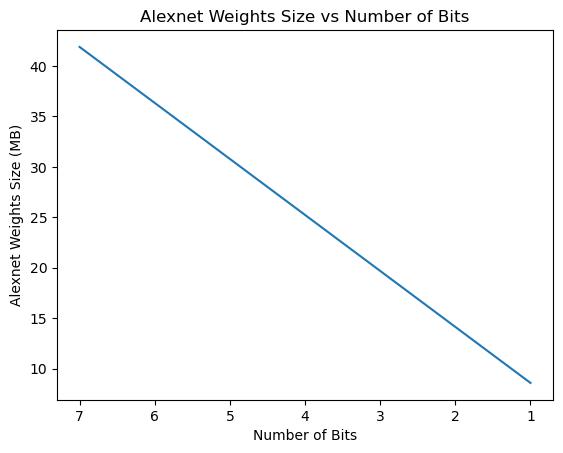

In [31]:
plt.plot(bit_lengths,compressed_sizes)
plt.gca().invert_xaxis()
plt.xlabel('Number of Bits')
plt.ylabel('Alexnet Weights Size (MB)')
plt.title('Alexnet Weights Size vs Number of Bits')
plt.savefig(fig_path / 'alex_weights_v_bits.png')

# MSE Computer

In [ ]:
# Flatten and Concatenate Entire Network

In [50]:
x = torch.tensor([[0,1,2],[3,4,5]])
y = torch.tensor([[6,7,8],[9,10,11]])
z = torch.tensor([[0,1,2],[3,4,5]])
a = torch.tensor([[6,7,8],[9,10,11]])

In [51]:
z = torch.tensor([])

In [52]:
z = torch.concatenate((z.flatten(),x.flatten()))
z

tensor([0., 1., 2., 3., 4., 5.])

In [53]:
z = torch.concatenate((z.flatten(),y.flatten()))
z

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [49]:
z = torch.concatenate((z,a.flatten()))
z

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  6,  7,  8,  9, 10, 11])

In [63]:
def flatten_model(model):
    flattened_model = torch.tensor([])
    for layer in [*model.features,*model.classifier]:
        try:
            weights = layer.weight.detach()
            flattened_model = torch.concatenate((flattened_model, weights.flatten()))
        except (TypeError, AttributeError):
            pass
    return flattened_model

In [65]:
flatten_model(alexnet).shape

torch.Size([44421824])

In [68]:
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,10)

alexnet.load_state_dict(torch.load(f'./model_20240603_151633_final_frozen_alexnet',map_location=device))
alexnet.eval()
output = ''
for bit_length in bit_lengths:
    model = create_model(bit_length)
    flattened_alexnet = flatten_model(alexnet)
    flattened_quantized_alexnet = flatten_model(model)
    model_size = flattened_alexnet.shape[0]
    MSE = torch.sum(torch.pow(flattened_alexnet - flattened_quantized_alexnet, 2)) / model_size
    print(f'{bit_length} model MSE: {MSE}')
    output += f'{bit_length} model MSE: {MSE}\n'
print(output)

Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


7 model MSE: 3.9068904555961126e-08


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


6 model MSE: 6.442089528491124e-08


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


5 model MSE: 1.7218215475622856e-07


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


4 model MSE: 5.99545160184789e-07


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


3 model MSE: 2.2738106508768396e-06


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


2 model MSE: 2.2738106508768396e-06


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


1 model MSE: 0.0002048963215202093
7 model MSE: 3.9068904555961126e-08
6 model MSE: 6.442089528491124e-08
5 model MSE: 1.7218215475622856e-07
4 model MSE: 5.99545160184789e-07
3 model MSE: 2.2738106508768396e-06
2 model MSE: 2.2738106508768396e-06
1 model MSE: 0.0002048963215202093



In [69]:
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,10)

alexnet.load_state_dict(torch.load(f'./model_20240603_151633_final_frozen_alexnet',map_location=device))
alexnet.eval()
output = ''
for bit_length in bit_lengths:
    model = create_model(bit_length)
    flattened_alexnet = flatten_model(alexnet)
    flattened_quantized_alexnet = flatten_model(model)
    model_size = flattened_alexnet.shape[0]
    MSE = torch.sum(torch.abs(flattened_alexnet - flattened_quantized_alexnet)) / model_size
    print(f'{bit_length} model MAE: {MSE}')
    output += f'{bit_length} model MAE: {MSE}\n'
print(output)

Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


7 model MAE: 0.00016158449579961598


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


6 model MAE: 0.0002035994693869725


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


5 model MAE: 0.00029426516266539693


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


4 model MAE: 0.00047445064410567284


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


3 model MAE: 0.0008231321698985994


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


2 model MAE: 0.0008231321698985994


Using cache found in C:\Users\Elijah/.cache\torch\hub\pytorch_vision_v0.10.0


1 model MAE: 0.007130596786737442
7 model MAE: 0.00016158449579961598
6 model MAE: 0.0002035994693869725
5 model MAE: 0.00029426516266539693
4 model MAE: 0.00047445064410567284
3 model MAE: 0.0008231321698985994
2 model MAE: 0.0008231321698985994
1 model MAE: 0.007130596786737442

